# PinT Hot Rod

## What is this Hot Rod???
The Hot Rod detector works by estimating an embedded estimate as well as an extrapolated estimate and subtracting the two. This gives a quantitiy that is one order higher than the error estimates and which can be used for fault detection by comparing to a tolerance.
$$\| \epsilon_\mathrm{embedded} - \epsilon_\mathrm{extrapolation}\| = \Delta \leq \mathrm{TOL},$$
Where the last equality is the condition for accepting a time step. If it's violated, we restart.

## Embedded Error
The idea is super simple: Take two methods of order $k$ and $k-1$ and subtract their solutions:
$$\|u^{(k-1)} - u^{(k)}\| = \|u^{(k-1)} - u^* - \left(u^{(k)}-u^*\right)\| = e^{(k-1)} + \mathcal{O}\left(\Delta t^{k+1}\right).$$
Note that with SDC, this could not be easier since the order rises by one with each sweep.

## Extrapolation Error
This is a bit messy, but I find it comprehensible when looking at it as a finite difference method.
In finite differences, you do Taylor expansions around a point $x$ in space to neighboring points, such that the function and derivative evaluations are always at $x$, but the coefficients depend on the distance and some Taylor business.
Then, you solve a system of equations to cancel out all derivatives of the function except for the one you're looking for by summing up all Taylor expansions in a weighted sort of way, where the solution to the system of equations you're solving are the weights.

So far, I just (tried) to explain finite difference methods, now for the extrapolation error part.
You want to get an extrapolated solution to compare to the solution obtained by the time marching scheme (SDC) and subtract in a way that only the local error remains.
The extrapolated solution is exactly where the finite differences come in: You derive a finite difference stencil that is backwards in time and that not only uses the function values, but also the first derivatives, which you know from right hand side evaluations.
The crucial point here is, that you don't solve for a derivative, but for the function itself (the zeroth derivative).
As for the order, we want the Taylor expansion error to be negligible compared to the error of the time marching scheme, which we are trying to estimate.
So when we do $k$ sweeps to get an order $k$ method with order $k+1$ error, we should Taylor expand to order $k+2$.
This requires us to store also $k+2$ instances of solutions or RHS evaluations of previous steps in memory.
And at the same time, you compute the solution to the time step with SDC.

Now you subtract the two, but what you get is not exactly the local error, since you need to take care of how the error accumulates between all the steps that enter into the extrapolated error.
The initial conditions for the first step are considered exact, such that its sulution is exact plus one times the local error.
The second step starts out with these flawed initial conditions, so it's solution will be exact plus two times the local error and so on.
To me, this sounds like it is only really true for linear equations, but since the error should be small, this is maybe a good approximation, and it works well enough in practice.
To get the ratio between the difference of the extrapolated solution and the time marching solution and the actual error, you sum up the respective multiple of the local error carried by each solution with the associated coefficient in the finite difference stencil.
This can be extended to an adaptive scheme, by considering the ratio of the step size of the particular step to the step where you want to estimate the error, but let's not worry about that now.

### Time-Serial Test
For now, let's test this time-serial with an advection problem:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pySDC.helpers.stats_helper import filter_stats, sort_stats
from pySDC.implementations.collocation_classes.gauss_radau_right import CollGaussRadau_Right
from pySDC.implementations.problem_classes.AdvectionEquation_1D_FD import advection1d
from pySDC.implementations.sweeper_classes.generic_implicit import generic_implicit
from pySDC.implementations.controller_classes.controller_nonMPI import controller_nonMPI

from pySDC.core.Hooks import hooks

class log_data(hooks):

    def post_step(self, step, level_number):

        super(log_data, self).post_step(step, level_number)

        # some abbreviations
        L = step.levels[level_number]

        L.sweep.compute_end_point()

        self.add_to_stats(process=step.status.slot, time=L.time, level=L.level_index, iter=0,
                          sweep=L.status.sweep, type='u', value=L.uend[0])
        self.add_to_stats(process=step.status.slot, time=L.time, level=L.level_index, iter=0,
                          sweep=L.status.sweep, type='dt', value=L.dt)
        self.add_to_stats(process=step.status.slot, time=L.time, level=L.level_index, iter=0,
                          sweep=L.status.sweep, type='e_embedded', value=L.status.error_embedded_estimate)
        self.add_to_stats(process=step.status.slot, time=L.time, level=L.level_index, iter=0,
                          sweep=L.status.sweep, type='e_extrapolated', value=L.status.error_extrapolation_estimate)


def run(num_procs):
    """
    A simple test program to do PFASST runs for the heat equation
    """

    # initialize level parameters
    level_params = dict()
    level_params['dt'] = 5e-3
    level_params['e_tol'] = 1e-8

    # initialize sweeper parameters
    sweeper_params = dict()
    sweeper_params['collocation_class'] = CollGaussRadau_Right
    sweeper_params['num_nodes'] = 3
    sweeper_params['QI'] = 'IE'
    sweeper_params['QE'] = 'PIC'

    problem_params = {
        'freq': 2,
        'nvars': 2**9,
        'c': 1.,
    }

    # initialize step parameters
    step_params = dict()
    step_params['maxiter'] = 5

    # initialize controller parameters
    controller_params = dict()
    controller_params['logger_level'] = 30
    controller_params['hook_class'] = log_data
    controller_params['use_HotRod'] = True
    controller_params['HotRod_tol'] = 20
    controller_params['use_adaptivity'] = False
    controller_params['mssdc_jac'] = False

    # fill description dictionary for easy step instantiation
    description = dict()
    description['problem_class'] = advection1d  # pass problem class
    description['problem_params'] = problem_params  # pass problem parameters
    description['sweeper_class'] = generic_implicit  # pass sweeper
    description['sweeper_params'] = sweeper_params  # pass sweeper parameters
    description['level_params'] = level_params  # pass level parameters
    description['step_params'] = step_params

    # set time parameters
    t0 = 0.0
    Tend = 2e1
    Tend = 20*level_params['dt']

    # instantiate controller
    controller_class = controller_nonMPI
    controller = controller_class(num_procs=num_procs, controller_params=controller_params,
                                  description=description)

    # get initial values on finest level
    P = controller.MS[0].levels[0].prob
    uinit = P.u_exact(t0)

    # call main function to get things done...
    uend, stats = controller.run(u0=uinit, t0=t0, Tend=Tend)
    return stats

/var/folders/zl/pxyz2x2x591c234cc02rcn_40000gn/T/ipykernel_73834/1542516572.py:5: DeprecationWarning: This import is deprecated and will be removed in future versions.To use this type of collocation, please use the new generic Collocation class in pySDC.implementations.collocations, for example:
coll = Collocation(num_nodes, tleft, tright, node_type='LEGENDRE', quadType='RADAU-RIGHT')

  from pySDC.implementations.collocation_classes.gauss_radau_right import CollGaussRadau_Right


In [2]:
def plot_hotrod(stats, ax):
    # convert filtered statistics to list of iterations count, sorted by process
    t = np.array(sort_stats(filter_stats(stats, type='u'), sortby='time'))[:, 0]
    e_em = np.array(sort_stats(filter_stats(stats, type='e_embedded'), sortby='time'))[:, 1]
    e_ex = np.array(sort_stats(filter_stats(stats, type='e_extrapolated'), sortby='time'))[:, 1]
    ready = np.logical_and(e_ex != np.array(None), e_em != np.array(None))
    
    ax.plot(t, e_em, label=r'$\epsilon_\mathrm{embedded}$')
    ax.plot(t[ready], e_ex[ready], label=r'$\epsilon_\mathrm{extrapolated}$', linestyle='--', marker='*')
    ax.plot(t[ready], e_em[ready]-e_ex[ready], label=r'$\Delta$')
    ax.legend(frameon=False)
    ax.set_xlabel(r'$t$')
    ax.set_yscale('log')

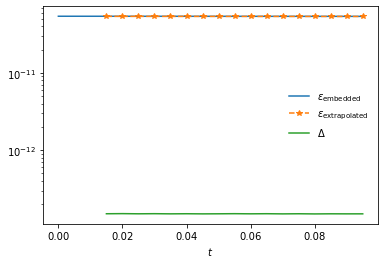

In [3]:
stats_serial = run(1)
fig, ax = plt.subplots(1,1)
plot_hotrod(stats_serial, ax)
plt.show()

As we can see, the errors match up nicely and their difference is somewhat smaller. Massive success! Now what happens if we go PinT?

## Going PinT with Block Gauss-Seidel
### Extrapolation Error
One weakness of the extrapolation estimate is the memory overhead. But wait a minute! In block Gauss-Seidel, we are computing multiple steps at the same time, which need to be in memory anyways, so let's use that! The simplest thing we can do, is use one more process than we need steps to store from such that we compute the extrapolated error only on the last step and use all earlier steps for the extrapolation. Let's not worry about the effects of PinT for now.

### Embedded Error
Let's not do anything different for now and see what we get.

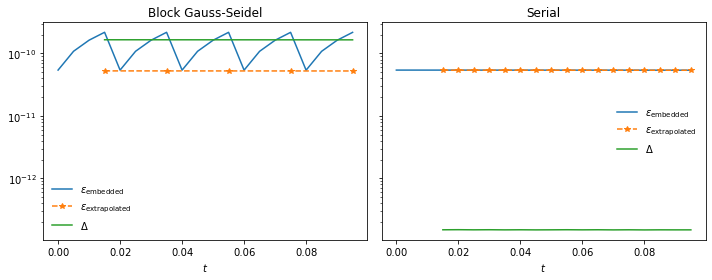

In [4]:
fig, axs = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(10, 4))
stats_par = run(4)
plot_hotrod(stats_par, axs[0])
plot_hotrod(stats_serial, axs[1])
axs[0].set_title('Block Gauss-Seidel')
axs[1].set_title('Serial')
fig.tight_layout()
plt.show()

As you can see, the extrapolation error estimate is now spaced further appart, since we only compute it on every fourth step, but it didn't really change from the serial solution, which is weird! Smells like fish!
The embedded estimate on the other hand, is growing from step to step within the block, which is extremely reasonable, I think! What we end up with is two totally different error estimates and taking their difference is no use to detecting errors.

If you look closely, though, you see that the embedded error estimate is incremented by itself between steps. Let me plot what I mean:

In [8]:
def plot_hotrod_embedded_weirdness(stats, ax):
    # convert filtered statistics to list of iterations count, sorted by process
    t = np.array(sort_stats(filter_stats(stats, type='u'), sortby='time'))[:, 0]
    e_em = np.array(sort_stats(filter_stats(stats, type='e_embedded'), sortby='time'))[:, 1]
    e_ex = np.array(sort_stats(filter_stats(stats, type='e_extrapolated'), sortby='time'))[:, 1]
    ready = np.logical_and(e_ex != np.array(None), e_em != np.array(None))
    
    e_em_fix = e_em / (np.arange(len(e_em))%4+1)
    
    ax.plot(t, e_em_fix, label=r'$\epsilon_\mathrm{embedded}$ fix', linestyle='-')
    ax.plot(t[ready], e_em_fix[ready]-e_ex[ready], label=r'$\Delta$ fix')
    ax.legend(frameon=False)
    ax.set_xlabel(r'$t$')
    ax.set_yscale('log')

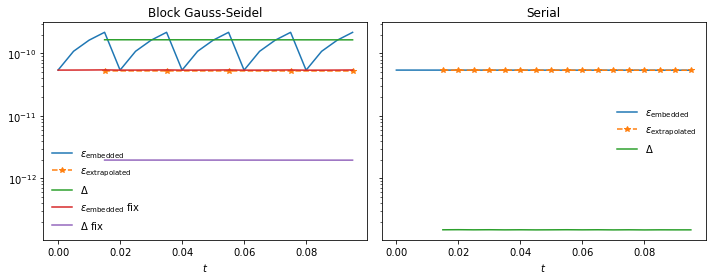

In [6]:
fig, axs = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(10, 4))
plot_hotrod(stats_par, axs[0])
plot_hotrod(stats_serial, axs[1])
plot_hotrod_embedded_weirdness(stats_par, axs[0])
axs[0].set_title('Block Gauss-Seidel')
axs[1].set_title('Serial')
fig.tight_layout()
plt.show()

Look at the new lines labelled fix in the left plot. In the eye norm we fixed all our problems, but the difference is larger. Let's take a closer look:

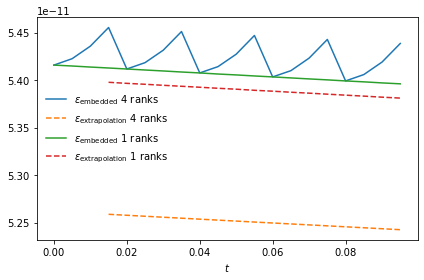

In [9]:
fig, ax = plt.subplots(1, 1)
def plot_hotrod_comp(stats, ax, size):
    # convert filtered statistics to list of iterations count, sorted by process
    t = np.array(sort_stats(filter_stats(stats, type='u'), sortby='time'))[:, 0]
    e_em = np.array(sort_stats(filter_stats(stats, type='e_embedded'), sortby='time'))[:, 1]
    e_ex = np.array(sort_stats(filter_stats(stats, type='e_extrapolated'), sortby='time'))[:, 1]
    ready = np.logical_and(e_ex != np.array(None), e_em != np.array(None))
    
    e_em_fix = e_em / (np.arange(len(e_em))%size+1)
    
    ax.plot(t, e_em_fix, label=r'$\epsilon_\mathrm{embedded}$'+f' {size} ranks', linestyle='-')
    ax.plot(t[ready], e_ex[ready], label=r'$\epsilon_\mathrm{extrapolation}$'+f' {size} ranks', linestyle='--')
    ax.legend(frameon=False)
    ax.set_xlabel(r'$t$')

plot_hotrod_comp(stats_par, ax, 4)
plot_hotrod_comp(stats_serial, ax, 1)
fig.tight_layout()
plt.show()

This is now a comparison of just the error estimates in a linear scale. As you can see, going PinT changed the extrapolation error by remarkably little, while we still get some increment between steps with the embedded estimate, but it's really small compared to the overall error.
My feeling is that this is too easy! What did I miss? Why would this work? These questions that call for someone who acutally knows what's going on, like Thibaut!

Please note that I made the same test with the Piline equation, which is still linear, but a bit more interesting and found the same result: Dividing the embedded error by the rank + 1 brings it very close to the extrapolated error and both are very close to the time-serial result.